In [1]:
# Jade Chongsathapornpong, August 2023
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import larch.math.convolution1D as c1d
from larch.io import read_ascii
from larch.xafs import sort_xafs, pre_edge, autobk
#%matplotlib nbagg
%matplotlib inline

# Comparing spectra to FDMNES simulations
To load experimental data and compare it to FDMNES calculated data. This was previously in `xas-pca-compare`, which got a bit too long. 

In [2]:
edges = {'Co': 7709, 'Cu': 8979, 'Ni': 8333, 'Zn': 9658}
### Zn K-edge ###
root = r'../Data/BM23_Averaging_PyMCA/Zn_Kedge_Old'
# This is everything to plot
# names_all = ['HEO-SSR_RT', 'W29_HEO-Ni_RTInit', 'W29_HEO-Ni_RTFinal', 'W29_HEO-Ni_900C', 
#          'W30_HEO-Mg_RTInit', 'W30_HEO-Mg_RTFinal', 'W30_HEO-Mg_900C',
#          'W32_HEO-Co_RT', 'W36_Zn_RTInit', 'W36_Zn_RTFinal', 'W36_Zn_900C',
#          'W37_ZnCo_RTInit', 'W37_ZnCo_RTFinal', 'W37_ZnCo_900C',
#          'W39_HEO_RTInit', 'W39_HEO_RTFinal', 'W39_HEO_900C',
#          'W46_ZnMg_RT', 'ZnO_KOCH_RT']

### Cu K-edge ###
# root = r'../Data/BM23_Averaging_PyMCA/Cu_Kedge'
# names_all = ['HEO-SSR_RT', 'W29_HEO-Ni_RTInit', 'W29_HEO-Ni_RTFinal', 'W29_HEO-Ni_900C', 
#          'W30_HEO-Mg_RTInit', 'W30_HEO-Mg_RTFinal', 'W30_HEO-Mg_900C', 'W31_HEO-Zn_RT',
#          'W39_HEO_RTInit', 'W39_HEO_RTFinal', 'W39_HEO_900C',
#          'CuO_Aldritch_RT']

### Co K-edge ###
# root = r'../Data/BM23_Averaging_PyMCA/Co_Kedge_Old'
# names_all = ['HEO-SSR_RT', 'W29_HEO-Ni_RTInit', 'W29_HEO-Ni_RTFinal', 'W29_HEO-Ni_900C', 
#          'W30_HEO-Mg_RTInit', 'W30_HEO-Mg_RTFinal', 'W30_HEO-Mg_900C', 'W31_HEO-Zn_RT',
#          'W35_Co_RTInit', 'W35_Co_RTFinal', 'W35_Co_900C',
#          'W37_ZnCo_RTInit', 'W37_ZnCo_RTFinal', 'W37_ZnCo_900C',
#          'W39_HEO_RTInit', 'W39_HEO_RTFinal',
#          'W40_CoNi_RT', 'W41_CoCu_RT', 'W42_CoMg_RT', 'W47_Co-doped-ZnO_RT', 'CoO_FDR_RT'] #  'W39_HEO_900C' removed because it's too short?

In [33]:
def larch_load(path, name, labels='energy_cenc, mu_fluo', fdmnes_edge=None):
    g = read_ascii(path, labels=labels)
    g.is_frozen = False
    g.datatype = 'xas'
    if fdmnes_edge is not None:
        g.data[0,:] = g.data[0,:] + fdmnes_edge
    g.xdat = 1000.*g.data[0,:] if max(g.data[0,:] < 100) else g.data[0,:]
    g.ydat = g.data[1,:]/1.
    g.yerr = 1.
    g.energy = g.xdat
    g.mu = g.ydat
    sort_xafs(g, overwrite=True, fix_repeats=True)
    g.groupname = name
    g.energy_orig = g.energy[:]
    g.energy_shift = 0. # this could be taken as an argument later?
    g.energy = g.xdat = g.energy_orig + g.energy_shift
    pre_edge(g) # use defaults for pre and post-edge normalization
    return g

def E_mu_from_names(names):
    energies = []
    mus = []
    for name in names:
        path = os.path.join(root, name + '.csv')
        lgrp = larch_load(path, name)
        energies.append(lgrp.energy)
        mus.append(lgrp.mu)
    return energies, mus

def scantree(path):
        # recursive search yielding a generator
        for entry in os.scandir(path):
            if entry.is_dir(follow_symlinks=False):
                yield from scantree(entry.path) 
            else:
                yield entry
def read_ref(name, search_root, E0):
    """Looks for name.txt in search_root. If it's not found, performs a recursive search."""
    path = os.path.join(search_root, name + '.txt')
    for entry in scantree(search_root):
        if not entry.is_file():
            continue
        filename = os.path.basename(entry.path)
        if filename == name + '.txt':
            print("Reading from", entry.path)
            g = larch_load(entry.path, name, labels='Energy, xanes', fdmnes_edge=E0)
    E = g.energy
    mu = g.mu
    return E, mu

def conv_ref(E, mu, gammas, sig, E0):
    mu_conv0 = mu#c1d.conv_fast(E, mu, gammas, e_cut=E0-0.1, kernel='lor')
    return c1d.conv_fast(E, mu_conv0, np.array([sig for e in E]), e_cut=E0-0.1, kernel='gauss')
    
def ref_combo(target, search_root, E0, conv=True):
    """Args:
        - target (list): of tuples (name (str), fraction (float))
        - search_root (str): path where the references are contained (can have subfolders)
    Returns:
        Energy array, and weighted sum of the spectra from the target names. 
        Assumes they have the same energy axis.
        Normalizes so that max of the sum is 1.
    Note this is poorly designed, as it depends on stuff defined outside the function.
    It also calls scantree more often than it needs to.
    But it's convenient.
    """
    ret = None
    for name, fraction in target:
        # load the reference
        E, mu = read_ref(name, search_root, E0)
        
        # convolve
        gammas = c1d.lin_gamma(E, gamma_hole=0.5, linbroad=(12, 0 + E0, 50 + E0))
        sig_gauss = 1.2
        mu_conv = conv_ref(E, mu, gammas, sig_gauss, E0) if conv else mu
        if save_convs and conv:
            np.savetxt(os.path.join(ref_root, name + '_conv.txt'), mu_conv)
        
        # add
        mu_conv = mu_conv * fraction
        if ret is None:
            ret = mu_conv
        else:
            ret += mu_conv
    ret = ret / np.max(ret)
    return E, ret

In [34]:
energies, mus = E_mu_from_names(names_all)

Reading from FDMNES\outputs\NiCo2O4_Ni-Sp_28.txt
(1031,)
Reading from FDMNES\outputs\NiO_Ni-R_28.txt
(1422,)


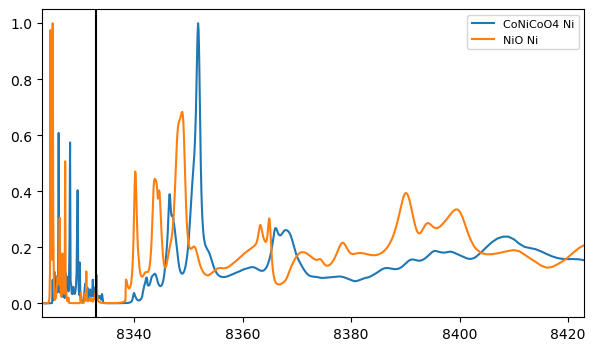

In [37]:
sample = None

ref_root = r'FDMNES\outputs'
# targets = [#[('CoO_Oh', 1.)], 
#            [('Co3O4_Oh', 0.666), ('Co3O4_Td', 0.333)],
#            [('Co3O4_Co-Sp_27_2', 0.666), ('Co3O4_Co-Sp_27_1', 0.333)]]
#            #[('NiCo_Co-Sp_27_Kedge_3', 0.666), ('NiCo_Co-Sp_27_Kedge_1', 0.167)],
#            #[('CuCo_Co-Sp_27_Kedge', 1.)],
#            #[('Zn037Co263_Co-Sp_27_Kedge_3', 2.), ('Zn037Co263_Co-Sp_27_Kedge_1', 0.630)], 
#            # [('ZnCo_Co-Sp_27_Kedge', 1.)]]
# scales = [1, 1]#, 0.73, 1, 1, 1]
# labels = ['Co3O4 r=6', 'Co3O4 r=7']

# targets = [[('CuCo2O4_Cu-Sp_29', 1.)],
#            [('CuO_Cu-T_29', 1.)]]
# scales = [1,1]
# labels = ['CuCo2O4 Cu', 'CuO Cu']

# targets = [[('ZnO_Zn-W_30', 1.)],
#            [('Zn037Co263O396_Zn-Sp_30', 1.)],
#            [('ZnCo2O4_Zn-Sp2019_30', 1.)]]
# scales = [1,1,1]
# labels = ['ZnO Zn', 'Zn0.37Co2.63O4 Zn', 'ZnCo2O4 Zn']

targets = [[('NiCo2O4_Ni-Sp_28', 1.)],
           [('NiO_Ni-R_28', 1.)]]
scales = [1,1]
labels = ['CoNiCoO4 Ni', 'NiO Ni']

save_convs = False
edge_energy = 8333 # controls global shift of FDMNES reference spectra

fig, ax = plt.subplots(figsize=(7,4))

# plot experiment
if sample is not None:
    index = names_all.index(sample)
    ax.plot(energies[index], mus[index] / np.max(mus[index]), label=sample)

# plot simulated references
spec_offset = -0.
for target, scale, l in zip(targets, scales, labels):
    E, muconv = ref_combo(target, ref_root, edge_energy, conv=False)
    print(E.shape)
    ax.plot(E, (muconv * scale) + spec_offset, label=l)
    spec_offset -= 0.0

plt.xlim(edge_energy - 10, edge_energy + 90)
plt.axvline(edge_energy, color='k')
plt.legend(ncol=1, loc='upper right', fontsize=8)
#plt.tight_layout()
#plt.savefig('Output/Simulation/WAM37Final_v_ZnO-W_v_ZnSpinels', dpi=300)
plt.show()

# Exploring the DOS data
FDMNES produces information about the density of states around the absorption edge. Let's take a look at it, compared to the corresponding simulated spectrum.

In [ ]:
ref_root = 'FDMNES'
specfile = 'ZnCo_Co-Sp_27_Kedge'
dosfile = 'FDMNES/outputs/' + specfile + '_sd0.txt'
ene, spec = read_ref(specfile)
gammas = c1d.lin_gamma(E, gamma_hole=0.5, linbroad=(5, 0, 30))
spec = conv_ref(ene, spec, gammas, 1.)
dosdf = pd.read_csv(dosfile, delim_whitespace=True)
dosdf.columns

In [ ]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(10,6), gridspec_kw={'height_ratios': [1,1]})
ax1.set_title(specfile + ' Oh')
ax1.plot(ene, spec)
ax2.plot(dosdf['Energy'], dosdf['s'], label='s')
ax2.plot(dosdf['Energy'], dosdf['p'], label='p')
ax2.plot(dosdf['Energy'], dosdf['d'], label='d')
#ax2.set_yscale('log')
ax2.set_ylim(bottom=0.000001, top=10)
ax2.legend()
plt.savefig('Output/Simulation/' + specfile + '_sd0', dpi=300)
plt.show()